In [1]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

In [2]:
import os
from google.colab import drive

### Download The Dataset & Define The Transforms

In [3]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17653862.51it/s]


Extracting drive/My Drive/mnist/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to drive/My Drive/mnist/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 475461.46it/s]


Extracting drive/My Drive/mnist/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to drive/My Drive/mnist/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4391134.16it/s]


Extracting drive/My Drive/mnist/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to drive/My Drive/mnist/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4360386.53it/s]

Extracting drive/My Drive/mnist/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to drive/My Drive/mnist/MNIST_data/MNIST/raw



### Exploring The Data

In [4]:
# Example corrected approach to iterate through trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Get the next batch using next()

print(type(images))  # Print type of images
print(images.shape)  # Print shape of images tensor
print(labels.shape)  # Print shape of labels tensor


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


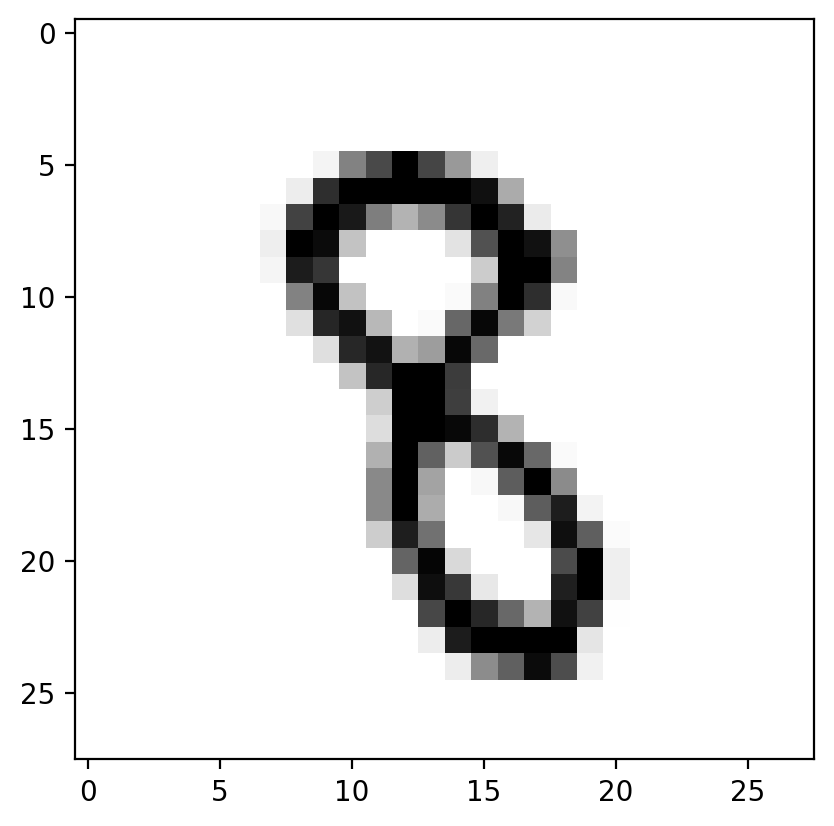

In [5]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

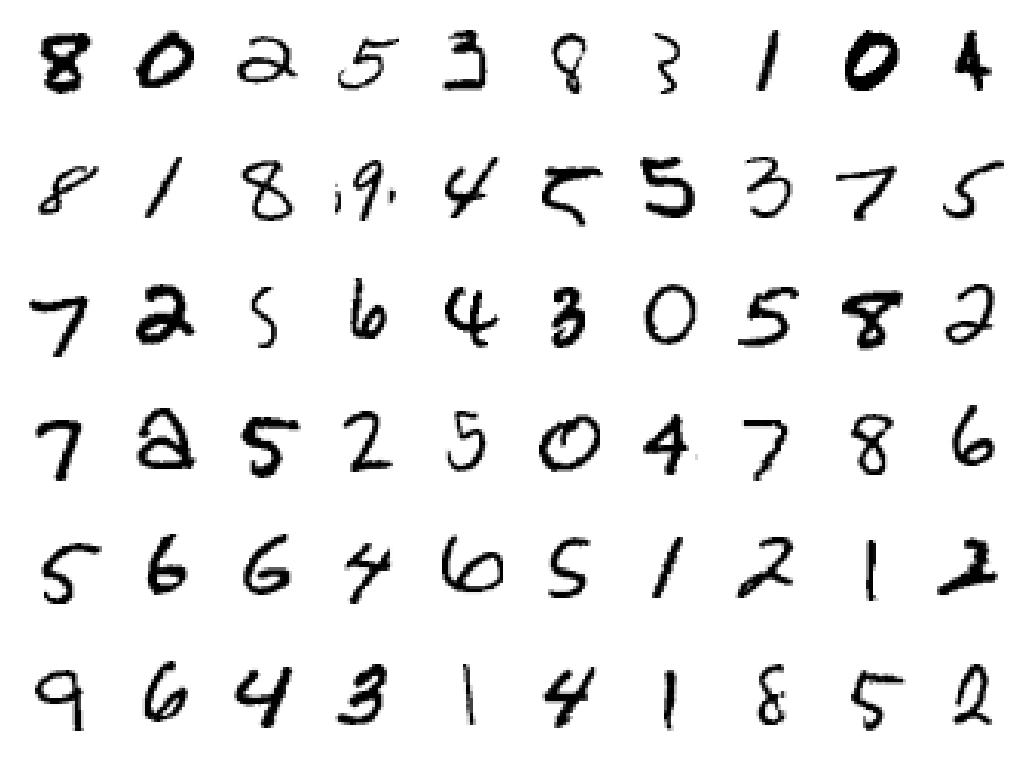

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Defining The Neural Network

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

In [7]:
from torch import nn

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

In [9]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images.cuda())
loss = criterion(logps, labels.cuda())

In [10]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        [-0.0022, -0.0022, -0.0022,  ..., -0.0022, -0.0022, -0.0022],
        [ 0.0074,  0.0074,  0.0074,  ...,  0.0074,  0.0074,  0.0074],
        ...,
        [-0.0060, -0.0060, -0.0060,  ..., -0.0060, -0.0060, -0.0060],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [ 0.0017,  0.0017,  0.0017,  ...,  0.0017,  0.0017,  0.0017]],
       device='cuda:0')


In [11]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [12]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images.cuda())
loss = criterion(output, labels.cuda())
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0312,  0.0321,  0.0014,  ...,  0.0039, -0.0299, -0.0228],
        [-0.0184, -0.0174,  0.0072,  ..., -0.0357, -0.0281, -0.0103],
        [-0.0103, -0.0035,  0.0345,  ..., -0.0005, -0.0250, -0.0138],
        ...,
        [-0.0049,  0.0134,  0.0011,  ...,  0.0096,  0.0003, -0.0303],
        [-0.0129,  0.0257,  0.0218,  ..., -0.0323,  0.0304,  0.0314],
        [-0.0327, -0.0341, -0.0253,  ...,  0.0248, -0.0213,  0.0097]],
       device='cuda:0', requires_grad=True)
Gradient - tensor([[ 0.0011,  0.0011,  0.0011,  ...,  0.0011,  0.0011,  0.0011],
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        ...,
        [-0.0027, -0.0027, -0.0027,  ..., -0.0027, -0.0027, -0.0027],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0020, -0.0020, -0.0020,  ..., -0.0020, -0.0020, -0.0020]],
       device='cuda:0')


In [13]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0312,  0.0321,  0.0014,  ...,  0.0039, -0.0299, -0.0228],
        [-0.0184, -0.0174,  0.0072,  ..., -0.0357, -0.0281, -0.0103],
        [-0.0103, -0.0036,  0.0345,  ..., -0.0005, -0.0250, -0.0138],
        ...,
        [-0.0049,  0.0134,  0.0011,  ...,  0.0096,  0.0003, -0.0303],
        [-0.0129,  0.0257,  0.0218,  ..., -0.0323,  0.0304,  0.0314],
        [-0.0327, -0.0341, -0.0253,  ...,  0.0249, -0.0212,  0.0097]],
       device='cuda:0', requires_grad=True)


### Core Training Of Neural Network

In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = model(images.cuda())
        loss = criterion(output, labels.cuda())

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 0.6309142525293934
Epoch 1 - Training loss: 0.28036641590853234
Epoch 2 - Training loss: 0.21955660383091935
Epoch 3 - Training loss: 0.17717922331372113
Epoch 4 - Training loss: 0.14942671039076186
Epoch 5 - Training loss: 0.12747333947716077
Epoch 6 - Training loss: 0.110656387953044
Epoch 7 - Training loss: 0.09811043563876738
Epoch 8 - Training loss: 0.08830120834782085
Epoch 9 - Training loss: 0.07924287788706945
Epoch 10 - Training loss: 0.07234728954303493
Epoch 11 - Training loss: 0.06664021926046387
Epoch 12 - Training loss: 0.06064245941242509
Epoch 13 - Training loss: 0.05663608596138934
Epoch 14 - Training loss: 0.05283980911522151

Training Time (in minutes) = 3.4375229676564536


In [15]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 5


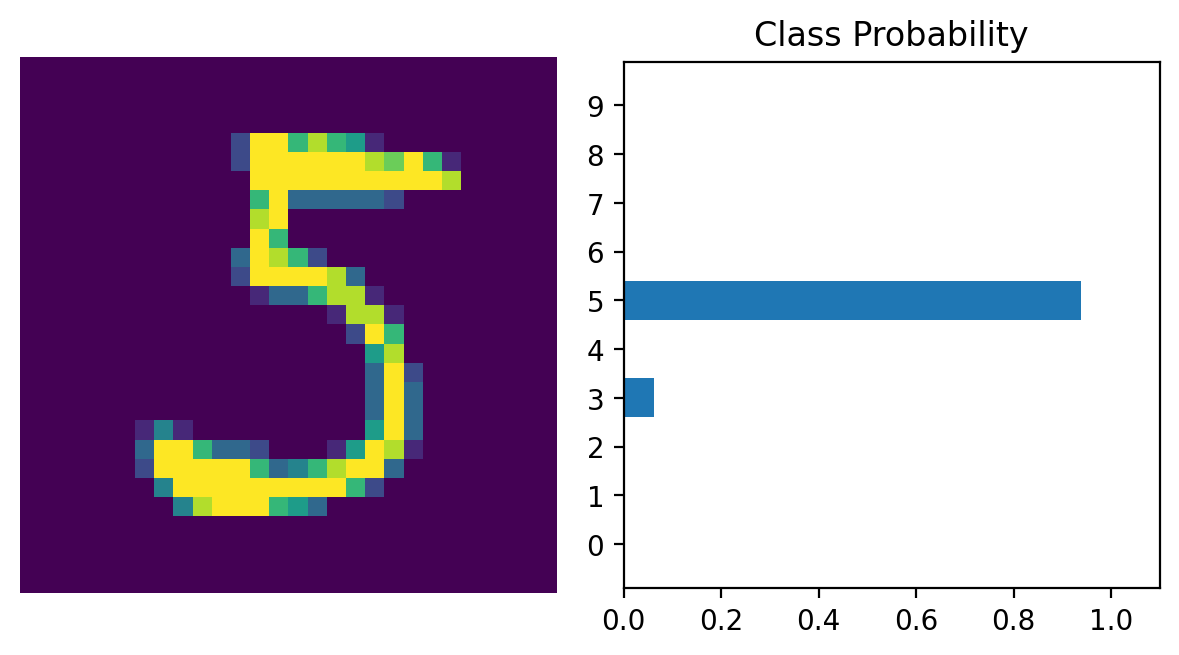

In [16]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img.cuda())

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

### Model Evaluation

In [17]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img.cuda())

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9721
